# Modelo de Kermack McKendrick

In [1]:
include("Taylor.jl")
using ADT


Use "Taylor(" instead.


Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [2]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 2 methods)

Error absoluto

In [3]:
eps_abs = 1e-20

1.0e-20

In [4]:
function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [5]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [6]:
function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 1 method)

In [7]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);

  0.771504 seconds (8.35 M allocations: 153.685 MB, 1.97% gc time)


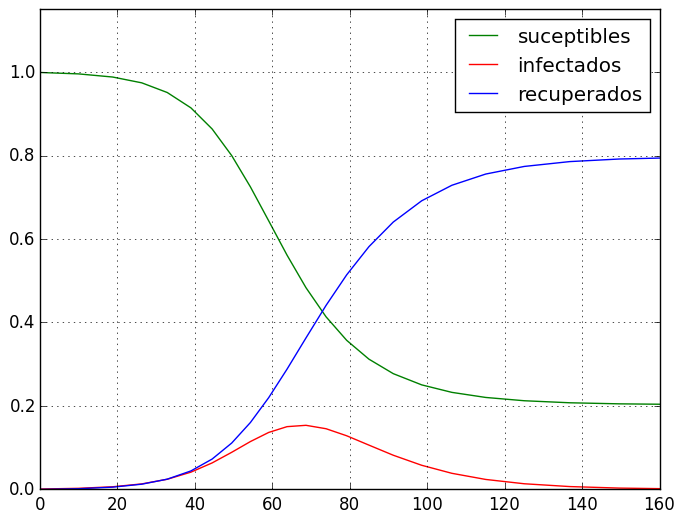

In [8]:
using PyPlot

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
axis([0,160,0,1.15])
grid()
legend()
show()

Ahora hagamos un diagrama fase de esto, donde no esperamos ningún comportamiento peculiar.

# Model SIRS con Nacimientos y Muertes

Ahora consideraremos que hay una taza de natalidad $\mu$, la cual asumiremos que es igual a la taza de mortalidad. Además, consideraremos una tasa de reincidencia f de la población recuperada. De este modo, la población presenta el siguiente flujo:
$\mathcal{S} \rightarrow \mathcal{I} \rightarrow \mathcal{R} \rightarrow \mathcal{S}$, por lo que el modelo se denomina **SIRS** (donde además, consideramos los nacimientos y muertes). Entonces, el modelo queda de la siguiemte manera:

\begin{array}{rcl} 
\frac{dS}{dt}  & = & - \frac{\beta S I}{N} + \mu (N - S) + f R  \\ 
\frac{dI}{dt} & = & \frac{\beta S I}{N} - \gamma I - \mu I  \\
\frac{dR}{dt} & = & \gamma I - \mu R - f R \\
\end{array}

Ahora, realizaremos la integración de este sistema de ecuaciones. Sólo requeriremos modificar la función de coeficientes para considerar los términos adicionales y, además, modificar el integrador para que considere los parámetros adicionales.

In [9]:
function coefs_SIRS(γ,β,μ,f,S_0,I_0,R_0,n=50)
    N=S_0+I_0+R_0
    
    s=[S_0]
    i=[I_0]
    r=[R_0]  #inicializar arrays 
    
    F1(S,I,R) = -(β/N)*S*I + μ*(I+R)+f*R #N-S=I+R pues N=I+R+S 
    F2(S,I) = (β/N)*S*I -γ*I -μ*I
    F3(I,R) = γ*I-μ*R-f*R
    
    f1=Taylor(0) #inicializamos f's pues las variables definidas en el for son locales
    f2=Taylor(0)
    f3=Taylor(0)
    
    for k in 1:n
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)

        f1=F1(Ts,Ti,Tr)
        f2=F2(Ts,Ti)
        f3=F3(Ti,Tr)
        
        S_0 = f1.pol[k]/k
        I_0 = f2.pol[k]/k
        R_0 = f3.pol[k]/k
        
        push!(s,S_0)
        push!(r,R_0)
        push!(i,I_0)
           
    end
    
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    
    return s,i,r
end

coefs_SIRS (generic function with 2 methods)

In [10]:
"""
Esta función integra la ecuación diferencial del modelo de Kermack-McKendrick SIRS discurito previamente. Sus parámetros son:
integrador_kermack(N=población total,I0=infectados inicialmente,t0=tiempo inicial,tf=tiempo final,γ=tasa de recuperación,
β=tasa de infección,μ=tasa de natalidad,f=tasa,n=numero de términos en los pols. de Taylor). 
Se consideran nacimientos y muertes, pero se asume que la tasa de natalidad es igual que la de mortalidad. Con esto,
la población total se mantiene constante
"""
function integrador_kermack_SIRS(N, I0, R0, t0, tf, gamma, beta,mu,f,n=50)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_SIRS(gamma, beta,mu,f, S0, I0, R0,n)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    
    return t,s,i,r
end

integrador_kermack_SIRS (generic function with 2 methods)

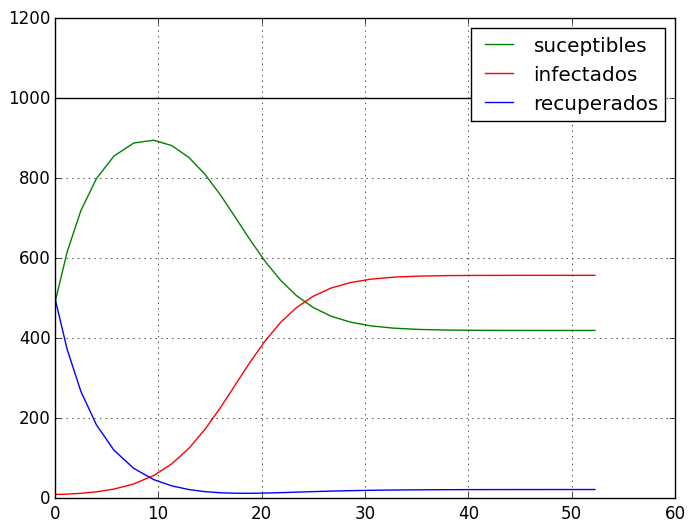

  1.064360 seconds (18.41 M allocations: 315.970 MB, 2.49% gc time)


In [11]:
N = 1.
I0 = N/100
R0 = .5
S0=N-I0-R0
ti = 0.
tf = 50.
beta = 0.5
gamma = 0.01
mu=0.2
f=.05

@time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta ,mu,f);

using PyPlot

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
plot(t,r+i+s,color="black")
grid()
legend()
show()

  0.729405 seconds (16.63 M allocations: 275.841 MB, 2.65% gc time)
  0.735867 seconds (16.63 M allocations: 275.841 MB, 2.12% gc time)
  0.716661 seconds (16.63 M allocations: 275.841 MB, 2.32% gc time)
  0.701379 seconds (16.63 M allocations: 275.841 MB, 2.34% gc time)
  0.736407 seconds (16.63 M allocations: 275.841 MB, 2.21% gc time)


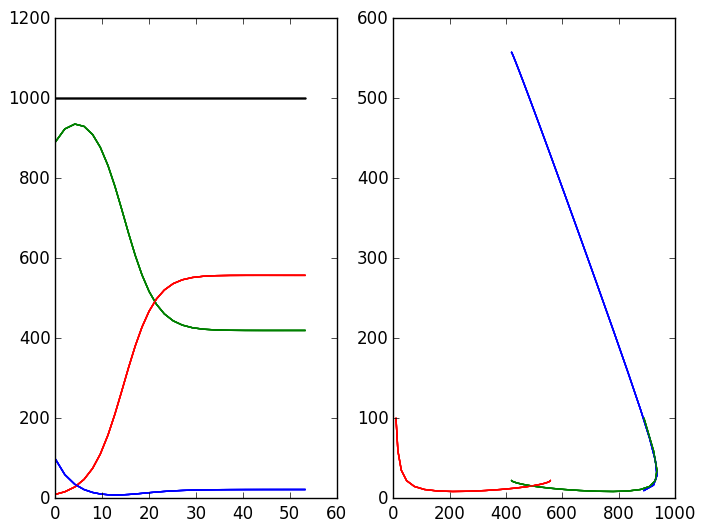

In [12]:
p=5

for j in 1:p
    
N = 1.
I0 = N/100
R0 = .1
S0=N-I0-R0
ti = 0.
tf = 50.
beta = 0.5
gamma = rand(0.01:0.1)
mu=0.2
f=.05


@time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta ,mu,f);

subplot(1,2,1)
plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
plot(t,r+i+s,color="black")

subplot(1,2,2)
    plot(s,i, color="blue")
    plot(s,r,color="green")
    plot(i,r,color="red")
end

# Para K especies (K=3)

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [13]:
eps_abs = 1e-50

1.0e-50

In [14]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fr = F2(gamma[i], Ti[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3 (generic function with 2 methods)

In [15]:
function k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

k_3 (generic function with 1 method)

In [16]:
N1 = .5
N2 = .3
N3 = .2
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
;

In [17]:
beta = rand(3,3)/3
gamma = rand(3)/8
;

In [18]:
t3, s3, i3, r3 = k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta);

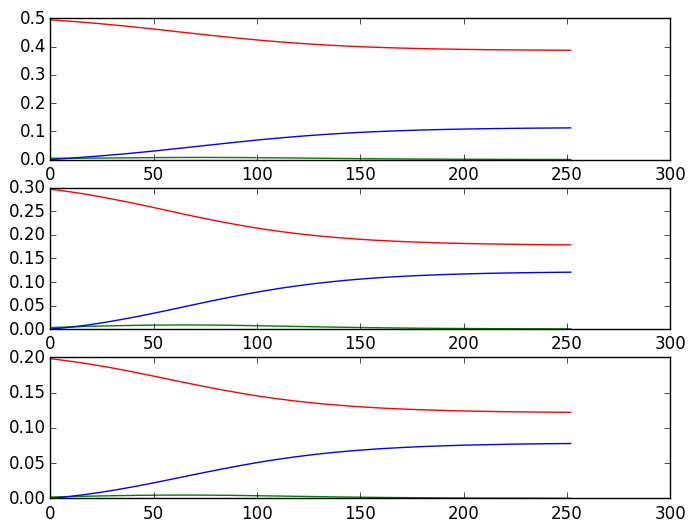

In [19]:
for k = 1:3
    subplot(3,1,k)
plot(t3, s3[k], color = "red")
plot(t3, i3[k], color = "green")
plot(t3, r3[k], color = "blue")
end

In [20]:
suma = 0
for k = 1:3
    suma += s3[k]+i3[k]+r3[k]
end

In [21]:
function coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    F3(phi_i,R) = phi_i*R
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fs += F3(phi[i],Tr[i])
            fr = F2(gamma[i], Ti[i])-F3(phi[i],Tr[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3_reincidencia (generic function with 2 methods)

In [22]:
function k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta, phi)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

k_3_reincidencia (generic function with 1 method)

In [23]:
beta = rand(3,3)/3
gamma = rand(3)/8
phi = rand(3)/3;

In [24]:
phi1 = ([0.011980782470983145,0.0122242866833574,0.12049916741165438])
gamma1 = ([0.0920466,0.0690204,0.0427661])
beta1 = Array{Float64}[[0.138933 ,0.0147811, 0.0747647], [0.0243735, 0.116977,0.0574383],[0.183494,0.109088,0.283322]]

3-element Array{Array{Float64,N},1}:
 [0.138933,0.0147811,0.0747647]
 [0.0243735,0.116977,0.0574383]
 [0.183494,0.109088,0.283322]  

In [25]:
phi0 = ([0.011980782470983145,0.0119,0.011980782470983145])
N1 = 1.
N2 = .2
N3 = .1
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250

250

In [26]:
@time t3, s3, i3, r3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma1, beta, phi1);

 14.489043 seconds (328.14 M allocations: 5.316 GB, 2.41% gc time)


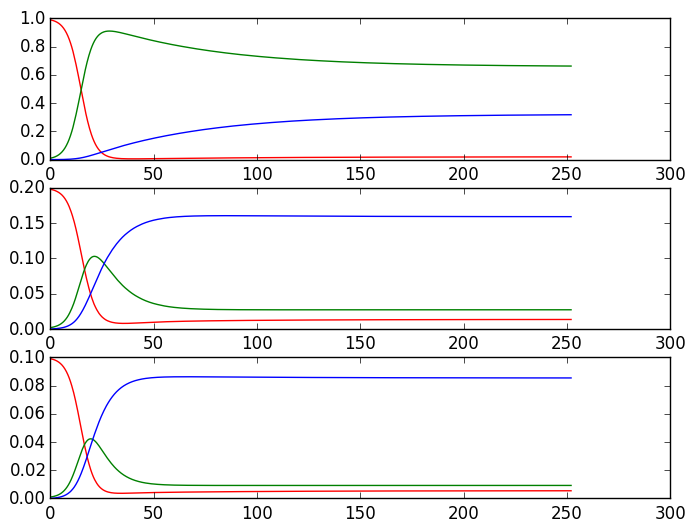

In [27]:
for k = 1:3
    subplot(3,1,k)
plot(t3, s3[k], color = "red")
plot(t3, i3[k], color = "green")
plot(t3, r3[k], color = "blue")
end

Muchos diagramas de fase a lo tonto.

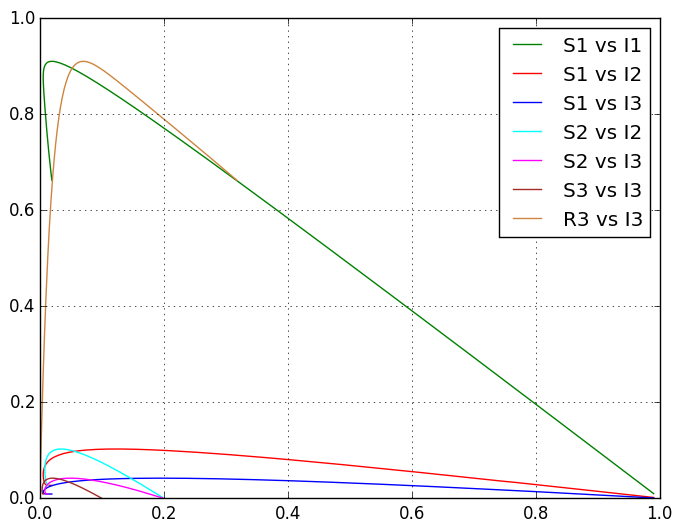

In [28]:
plot(s3[1],i3[1], color = "green", label = "S1 vs I1")
plot(s3[1],i3[2], color = "red", label = "S1 vs I2")
plot(s3[1],i3[3], color = "blue", label = "S1 vs I3")
plot(s3[2],i3[2], color = "cyan", label = "S2 vs I2")
plot(s3[2],i3[3], color = "magenta", label = "S2 vs I3")
plot(s3[3],i3[3], color = "brown", label = "S3 vs I3")
plot(r3[1],i3[1], color = "peru", label = "R3 vs I3")

grid()
legend()
show()

Definimos k_3 y coefs3 sin integrar R para ahorrar tiempo.

Ahora busquemos alguna bifurcación variando I0_1.

 11.613495 seconds (271.92 M allocations: 4.395 GB, 2.47% gc time)
 11.105819 seconds (258.32 M allocations: 4.176 GB, 2.44% gc time)
 10.727299 seconds (247.75 M allocations: 4.005 GB, 2.43% gc time)
  9.584079 seconds (228.11 M allocations: 3.687 GB, 2.47% gc time)
 12.317985 seconds (288.54 M allocations: 4.664 GB, 2.46% gc time)
 13.789047 seconds (318.75 M allocations: 5.152 GB, 2.46% gc time)
 14.590890 seconds (341.41 M allocations: 5.519 GB, 2.47% gc time)
 15.502531 seconds (361.05 M allocations: 5.836 GB, 2.47% gc time)
 16.240270 seconds (377.66 M allocations: 6.105 GB, 2.49% gc time)
 17.034277 seconds (392.77 M allocations: 6.349 GB, 2.48% gc time)


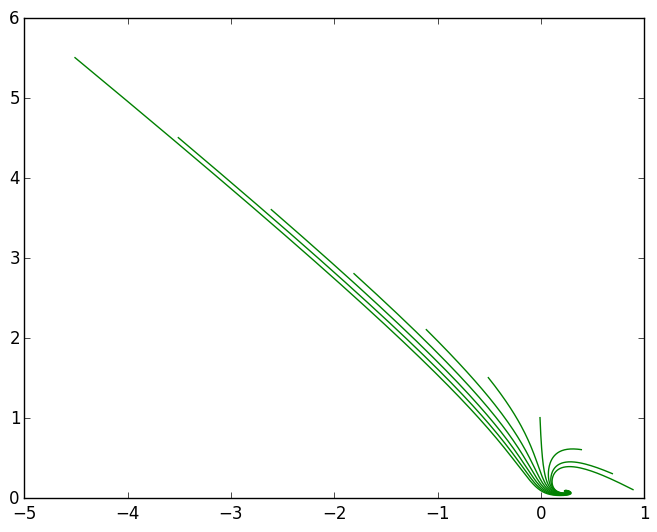

In [29]:
for i in 1:10
    I0_1 += 0.1*i
    @time t3, s3, i3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma1, beta, phi1);    
    plot(s3[1],i3[1], color = "green", label = "S1 vs I1")
end

Y podemos ver que hay un punto de bifurcación alrededor de (0,0) en el diagrama fase de S1 vs I1.